<a href="https://colab.research.google.com/github/aranjan-berkeley/nebula/blob/main/W266_RNN_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Here we are practicing use of RNN. Reference material is from

# lesson_3_DAN_CNN_RNN_Word2Vec_Embeddings_Classifier_plus_Attention

<a id = 'returnToTop'></a>

**Description:** Text classification on the IMDB movie dataset using i) Deep Averaging Networks, and ii) Convolutions Neural Nets (CNN) and pre-trained Word2Vec word embeddings.<br>

Section 1 deals with setup and prerequisites, can does not deserve a lot of discussion.
Data acquisition and preparation are handled in section 2, and section 3 looks at DANs and CNNs and now RNNs.




## Notebook Contents
  * 1. [Setup](#setup)
  * 2. [Creation of the Dataset](#creationOfDataset)  
  * 3. [Modeling](#modeling)
    * 3.1 [Averaging Network](#averagingNetwork)
    * 3.2 [Deep Averaging Network (DAN)](#modelDAN)
    * 3.3 [Convolutional Neural Net (CNN)](#modelCNN)
    * 3.4 [Recurrent Neural Net (RNN)](#modelRNN)
       * 3.4.2 [Class Exercise](#classExercise)
  * 4. [What about Attention](#modelAttention)
  * 5. [Answers](#answers)

# Gensim

Gensim is an open-source library for unsupervised topic modeling, document indexing, retrieval by similarity, and other natural language processing functionalities, using modern statistical machine learning.

# *Topic Modeling:*

https://en.wikipedia.org/wiki/File:Topic_model_scheme.webm


In statistics and natural language processing, a topic model is a type of statistical model for discovering the abstract "topics" that occur in a collection of documents. Topic modeling is a frequently used text-mining tool for discovery of hidden semantic structures in a text body. Intuitively, given that a document is about a particular topic, one would expect particular words to appear in the document more or less frequently: "dog" and "bone" will appear more often in documents about dogs, "cat" and "meow" will appear in documents about cats, and "the" and "is" will appear approximately equally in both.

# *Use of Gensim:*
Gensim includes streamed parallelized implementations of fastText, word2vec and doc2vec algorithms, as well as latent semantic analysis (LSA, LSI, SVD), non-negative matrix factorization (NMF), latent Dirichlet allocation (LDA), tf-idf and random projections.

Some of the novel online algorithms in Gensim were also published in the 2011 PhD dissertation Scalability of Semantic Analysis in Natural Language Processing of ***Radim Řehůřek***, the creator of Gensim.





In [1]:
#Install Gensim
!pip install gensim --quiet

Tensorflow data sets contains a large corpus of datasets for machine learning that can be used for research and training.
We will use imdb_review for text classification practice

***corpus*** - noun: corpus; plural noun: corpuses; plural noun: corpora
    1.a collection of written texts, especially the entire works of a particular author or a body of writing on a particular subject.

In [2]:
#install tensorflow-datasets
!pip install tensorflow-datasets --quiet

# Tensorflow-text


***Text processing tools for TensorFlow***

TensorFlow provides two libraries for text and natural language processing: KerasNLP and TensorFlow Text. KerasNLP is a high-level natural language processing (NLP) library that includes modern transformer-based models as well as lower-level tokenization utilities. It's the recommended solution for most NLP use cases. Built on TensorFlow Text, KerasNLP abstracts low-level text processing operations into an API that's designed for ease of use. But if you prefer not to work with the Keras API, or you need access to the lower-level text processing ops, you can use TensorFlow Text directly.



In [3]:
#install tensorflow-text
!pip install -U tensorflow-text --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 20.1 MB/s eta 0:00:00


pydot:

    is an interface to Graphviz
    can parse and dump into the DOT language used by GraphViz,
    is written in pure Python,

and networkx can convert its graphs to pydot.

In [4]:
!pip install pydot --quiet

***************************************************************
We are done with the installs.

Now we are ready to do the imports
**************************************************************

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt

import re


import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath


# for Amiya's practice
from numpy.linalg import norm

Helper Function:

4-window plot of loss and history comparing two models

In [6]:
# 4-window plot of loss and accuracy for two models, for comparison

def make_plot(axs,
              model_history1,
              model_history2,
              model_1_name='model 1',
              model_2_name='model 2',
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        for j, model_history in enumerate([model_history1, model_history2]):
            model_name = [model_1_name, model_2_name][j]
            ax1 = axs[i, j]
            ax1.plot(model_history.history[metric])
            ax1.plot(model_history.history['val_%s' % metric])
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)

Get word2vec model from nltk.
NLTK includes a pre-trained model which is part of a model that is trained on 100 billion words from the Google News Dataset. The full model is from https://code.google.com/p/word2vec/ (about 3 GB).

In [7]:
nltk.download('word2vec_sample')

[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


True

nltk has also pruned the model to only include the most common words (~44k words).

Let us load that model.


In [8]:
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

How many words in the model?

In [9]:
len(model)

43981

Each word is represented in the space of 300 dimensions:

In [10]:
len(model['university'])

300

How do the word vectors look like? As expected:

In [11]:
model['university']

array([-6.04623e-02, -4.63157e-02,  6.78263e-02,  1.14723e-01,
        1.06972e-01, -3.41069e-02,  6.74387e-02, -4.88349e-02,
       -1.23541e-02, -7.44151e-02,  4.84473e-02, -5.15480e-02,
        1.26932e-02,  3.08125e-02, -8.64301e-02,  4.38448e-03,
       -8.33294e-02, -3.04249e-02,  7.44151e-02, -5.30983e-02,
       -3.10063e-03,  6.78263e-02,  1.91851e-02, -1.34441e-03,
        1.92578e-03, -8.52673e-02, -5.89120e-02,  1.26932e-02,
       -4.68970e-02,  2.67429e-02,  5.27107e-02, -3.54635e-02,
       -2.28671e-02, -2.25765e-02,  3.21690e-02, -8.29419e-02,
        2.30609e-02,  3.72076e-02, -2.53864e-02,  5.73617e-02,
       -3.93392e-02,  2.06386e-02, -3.27504e-02,  1.53094e-02,
       -2.51926e-02, -3.99206e-02,  1.24025e-02, -4.57343e-02,
       -1.08522e-01,  1.27780e-03,  3.87579e-02, -7.79033e-02,
        6.82139e-02,  2.55802e-02,  9.37941e-02,  1.09491e-02,
       -1.08522e-01,  2.37392e-03,  2.83417e-03, -4.74784e-02,
       -7.90661e-02, -5.27107e-02,  2.36423e-02, -2.829

We can now build the embedding matrix and a vocabulary dictionary:

In [12]:
EMBEDDING_DIM = len(model['university'])      # we know... it's 300

# initialize embedding matrix and word-to-id map:
embedding_matrix = np.zeros((len(model) + 1, EMBEDDING_DIM))
vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(model.index_to_key):
    embedding_vector = model[word]

    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i

# we can use the last index at the end of the vocab for unknown tokens
vocab_dict['[UNK]'] = len(vocab_dict)

Let us explore our dictionary and embedding matrix for "university"

In [13]:
print(vocab_dict["university"])
A = embedding_matrix[vocab_dict["university"]]
print(A)
print(vocab_dict["college"])
B = embedding_matrix[vocab_dict["college"]]
#print(B)
C1 = embedding_matrix[vocab_dict["monkey"]]
#print(C1)
C2 = embedding_matrix[vocab_dict["ape"]]
#print(C2)


print("Cosine Similarity A and B:", np.dot(A,B)/(norm(A)*norm(B)))
print("Cosine Similarity A and C1:", np.dot(A,C1)/(norm(A)*norm(C1)))
print("Cosine Similarity C1 and C2:", np.dot(C1,C2)/(norm(C1)*norm(C2)))



4970
[-6.04622997e-02 -4.63156998e-02  6.78263009e-02  1.14722997e-01
  1.06972001e-01 -3.41068991e-02  6.74386993e-02 -4.88349013e-02
 -1.23541001e-02 -7.44151026e-02  4.84472997e-02 -5.15480004e-02
  1.26932003e-02  3.08125000e-02 -8.64301026e-02  4.38447995e-03
 -8.33294019e-02 -3.04249004e-02  7.44151026e-02 -5.30982986e-02
 -3.10062990e-03  6.78263009e-02  1.91850998e-02 -1.34441000e-03
  1.92577997e-03 -8.52672979e-02 -5.89120016e-02  1.26932003e-02
 -4.68970016e-02  2.67428998e-02  5.27107008e-02 -3.54635008e-02
 -2.28671003e-02 -2.25764997e-02  3.21689993e-02 -8.29418972e-02
  2.30608992e-02  3.72075997e-02 -2.53864005e-02  5.73616996e-02
 -3.93391997e-02  2.06386000e-02 -3.27504016e-02  1.53093999e-02
 -2.51925997e-02 -3.99205983e-02  1.24025000e-02 -4.57343012e-02
 -1.08521998e-01  1.27779995e-03  3.87579016e-02 -7.79033005e-02
  6.82139024e-02  2.55801994e-02  9.37941000e-02  1.09491004e-02
 -1.08521998e-01  2.37392006e-03  2.83416989e-03 -4.74784002e-02
 -7.90660977e-02 -5.

Explore the matrix

In [14]:
embedding_matrix.shape

(43982, 300)

In [15]:
embedding_matrix[:5, :5]

array([[ 0.0891758 ,  0.121832  , -0.0671959 ,  0.0477279 , -0.013659  ],
       [ 0.0526281 ,  0.013157  , -0.010104  ,  0.0540819 ,  0.0386715 ],
       [ 0.0786419 ,  0.0373911 , -0.0131472 ,  0.0347375 ,  0.0288273 ],
       [-0.00157585, -0.0564239 ,  0.00320281,  0.0422498 ,  0.15264399],
       [ 0.0356899 , -0.00367283, -0.065534  ,  0.0213832 ,  0.00788408]])

[Return to Top](#returnToTop)  
<a id = 'creationOfDataset'></a>
## 2. Creation of the Dataset

### 2.1 Data Acquisition

We will use the IMDB dataset delivered as part of the tensorflow-datasets library, and split into training and test sets. For expedience, we will limit ourselves in terms of train and test examples.

In [16]:
train_data, test_data = tfds.load(
    name="imdb_reviews",
    split=('train[:80%]', 'test[80%:]'),
    as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete2CFO7V/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete2CFO7V/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete2CFO7V/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


train and test load

In [17]:
train_examples, train_labels = next(iter(train_data.batch(20000)))
test_examples, test_labels = next(iter(test_data.batch(5000)))

In [18]:
train_examples[:4]

<tf.Tensor: shape=(4,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell a

In [19]:
train_labels[:4]

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 0, 0, 1])>

Next, we tokenize the data:

In [20]:
tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(train_examples)
test_tokens = tokenizer.tokenize(test_examples)

Does this look right?

In [21]:
train_tokens[0]

<tf.Tensor: shape=(116,), dtype=string, numpy=
array([b'This', b'was', b'an', b'absolutely', b'terrible', b'movie.',
       b"Don't", b'be', b'lured', b'in', b'by', b'Christopher', b'Walken',
       b'or', b'Michael', b'Ironside.', b'Both', b'are', b'great',
       b'actors,', b'but', b'this', b'must', b'simply', b'be', b'their',
       b'worst', b'role', b'in', b'history.', b'Even', b'their', b'great',
       b'acting', b'could', b'not', b'redeem', b'this', b"movie's",
       b'ridiculous', b'storyline.', b'This', b'movie', b'is', b'an',
       b'early', b'nineties', b'US', b'propaganda', b'piece.', b'The',
       b'most', b'pathetic', b'scenes', b'were', b'those', b'when',
       b'the', b'Columbian', b'rebels', b'were', b'making', b'their',
       b'cases', b'for', b'revolutions.', b'Maria', b'Conchita',
       b'Alonso', b'appeared', b'phony,', b'and', b'her', b'pseudo-love',
       b'affair', b'with', b'Walken', b'was', b'nothing', b'but', b'a',
       b'pathetic', b'emotional', b

### 2.2 Data Preparation

For the models we will use, we need to define a maximum sequence length (max number of tokens per movie review that we'll feed into our model). We'll cut off any tokens longer than that, and we'll pad shorter movie reviews with zeros at the end.

In [22]:
MAX_SEQUENCE_LENGTH = 128

Next, we define a simple function that converts the tokens of each movie review into their word2vec vocabulary index values.   

In [23]:
def docs_to_vocab_ids(tokenized_texts_list):
    """
    converting a list of strings to a list of lists of word ids
    """
    texts_vocab_ids = []
    for i, token_list in enumerate(tokenized_texts_list):

        # Get the vocab id for each token in this doc ([UNK] if not in vocab)
        vocab_ids = []
        for token in list(token_list.numpy()):
            decoded = token.decode('utf-8', errors='ignore')
            if decoded in vocab_dict:
                vocab_ids.append(vocab_dict[decoded])
            else:
                vocab_ids.append(vocab_dict['[UNK]'])

        # Truncate text to max length, add padding up to max length
        vocab_ids = vocab_ids[:MAX_SEQUENCE_LENGTH]
        n_padding = (MAX_SEQUENCE_LENGTH - len(vocab_ids))
        # For simplicity in this model, we'll just pad with uknown tokens
        vocab_ids += [vocab_dict['[UNK]']] * n_padding

        # Add this example to the list of converted docs
        texts_vocab_ids.append(vocab_ids)

        if i % 5000 == 0:
            print('Examples processed: ', i)

    print('Total examples: ', i)

    return np.array(texts_vocab_ids)

Now we can create training and test data that can be fed into the models of interest.



In [24]:
train_input = docs_to_vocab_ids(train_tokens)
test_input = docs_to_vocab_ids(test_tokens)

train_labels = np.array(train_labels)
print("now test labels")
test_labels = np.array(test_labels)

Examples processed:  0
Examples processed:  5000
Examples processed:  10000
Examples processed:  15000
Total examples:  19999
Examples processed:  0
Total examples:  4999
now test labels


Let's convince ourselves that the data looks correct.  We expect the train data to be an array of integer ids and the labels to be an array of zeroes and ones (since we are learning a binary classifier).

In [25]:
train_input[:2]

array([[21531, 25272, 12291,  7427, 37254, 43981,  6891, 12917, 38232,
        16915, 12929, 16182, 43981, 20526, 23487, 43981, 23807, 42958,
        35058, 43981, 19123, 35029, 41270, 29275, 12917, 32597, 20659,
          638, 16915, 43981,   174, 32597, 35058, 39971,  2326,  3636,
        22434, 35029, 43981, 33922, 43981, 21531, 34710, 16908, 12291,
        36880, 28137,  5376, 28038, 43981, 15402, 29155, 18063, 24951,
        17433, 17595,  8856, 14193, 43981, 43248, 17433,  6290, 32597,
         9001, 11511, 43981, 21807, 39168, 43981, 16856, 43981, 43981,
        23245, 43981,  8889,  1331, 43981, 25272, 31976, 19123, 43981,
        18063, 36309, 24099, 16915, 43981, 34710, 36633, 25272, 20413,
        43981, 33458, 14926, 43981, 12139, 12289, 39617, 36633,  9483,
        42958,  5589,  8092, 43981, 34516, 43981,  8092, 16182, 43981,
        39933, 43981, 12139,  2326, 32781, 32467,  7046, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
      

In [26]:
train_labels[:2]

array([0, 0])

[Return to Top](#returnToTop)  
<a id = 'modeling'></a>
## 3. Modeling

<a id = 'averagingNetwork'></a>
### 3.1 Averaging Network (AN) Model

Let us start by defining the embedding layer, then we'll average the embeddings and pass them into our classification layer.

In [27]:
an_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')

In [28]:
an_embedding_layer = Embedding(embedding_matrix.shape[0],
                               embedding_matrix.shape[1],
                               embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                               input_length=MAX_SEQUENCE_LENGTH,
                               trainable=False)

In [29]:
an_embeddings = an_embedding_layer(an_input_layer)

In [30]:
an_avg_embeddings = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1), name='averaging')(an_embeddings)

Finally lets define our output layer.



In [31]:
an_classification = tf.keras.layers.Dense(1,
                                          activation='sigmoid',
                                          name='an_classification')(an_avg_embeddings)

In [32]:
an_model = tf.keras.models.Model(inputs=an_input_layer, outputs=[an_classification])

In [33]:
an_model.compile(loss='binary_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,
                                                    beta_1=0.9,
                                                    beta_2=0.999,
                                                    epsilon=1e-07,
                                                    amsgrad=False,
                                                    name='Adam'),
                 metrics='accuracy')

In [34]:
an_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding (Embedding)       (None, 128, 300)          13194600  
                                                                 
 averaging (Lambda)          (None, 300)               0         
                                                                 
 an_classification (Dense)   (None, 1)                 301       
                                                                 
Total params: 13194901 (50.33 MB)
Trainable params: 301 (1.18 KB)
Non-trainable params: 13194600 (50.33 MB)
_________________________________________________________________


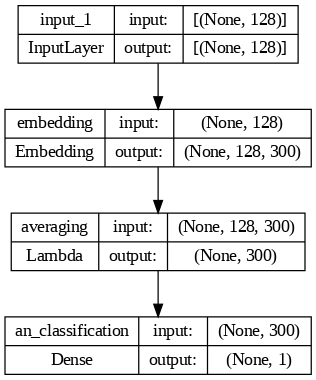

In [35]:
keras.utils.plot_model(an_model, show_shapes=True, dpi=90)

Let's look at the predictions and labels before training. Do those make sense?

In [36]:
print('predictions:\n', an_model.predict(train_input[:5]))
print('\n\nlabels:\n', train_labels[:5])

1/1 [==============================] - 3s 3s/step
predictions:
 [[0.4951862 ]
 [0.50321597]
 [0.49672922]
 [0.49782476]
 [0.49890384]]


labels:
 [0 0 0 1 1]


Let us train

In [37]:
an_history = an_model.fit(train_input,
                          train_labels,
                          validation_data=(test_input, test_labels),
                          batch_size=32,
                          epochs=20
                          )

Epoch 1/20
625/625 [==============================] - 4s 3ms/step - loss: 0.6882 - accuracy: 0.5649 - val_loss: 0.6841 - val_accuracy: 0.6378
Epoch 2/20
625/625 [==============================] - 2s 3ms/step - loss: 0.6781 - accuracy: 0.6495 - val_loss: 0.6757 - val_accuracy: 0.6470
Epoch 3/20
625/625 [==============================] - 2s 3ms/step - loss: 0.6693 - accuracy: 0.6611 - val_loss: 0.6685 - val_accuracy: 0.6528
Epoch 4/20
625/625 [==============================] - 2s 3ms/step - loss: 0.6615 - accuracy: 0.6669 - val_loss: 0.6618 - val_accuracy: 0.6612
Epoch 5/20
625/625 [==============================] - 3s 4ms/step - loss: 0.6545 - accuracy: 0.6708 - val_loss: 0.6560 - val_accuracy: 0.6584
Epoch 6/20
625/625 [==============================] - 2s 3ms/step - loss: 0.6482 - accuracy: 0.6769 - val_loss: 0.6504 - val_accuracy: 0.6656
Epoch 7/20
625/625 [==============================] - 2s 3ms/step - loss: 0.6423 - accuracy: 0.6841 - val_loss: 0.6452 - val_accuracy: 0.6686
Epoch 

Let us revisit the prediction after training? How does it look now, heh?

In [38]:
print('predictions:\n', an_model.predict(train_input[:5]))
print('\n\nlabels:\n', train_labels[:5])

1/1 [==============================] - 0s 19ms/step
predictions:
 [[0.32392794]
 [0.31456986]
 [0.59421504]
 [0.63124496]
 [0.528098  ]]


labels:
 [0 0 0 1 1]


That learned somewhat, can we do better?

[Return to Top](#returnToTop)  
<a id = 'modelDAN'></a>
### 3.2. Deep Averaging Network (DAN)

Now let's add some hidden layers after the averaging layer, to give our model more depth. The first and last layers are the same as above.

We'll also put our model creation code into a function, with variables for the things we can change (in this case, the hidden layers). Then we can try different values later.

In [39]:
def build_dan_model(hidden_layer_dims, dropout_rate, embeddings_trainable=False):
    dan_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    dan_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    dan_embeddings = dan_embedding_layer(dan_input_layer)
    dan_avg_embeddings = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1),
                                                name='averaging')(dan_embeddings)
    last_hidden_output = dan_avg_embeddings

    for i, h_dim in enumerate(hidden_layer_dims):
        last_hidden_output = tf.keras.layers.Dense(h_dim, activation='relu',
                                                   name='dan_hidden_%d' % i)(last_hidden_output)
        last_hidden_output = tf.keras.layers.Dropout(dropout_rate)(last_hidden_output)

    dan_classification = tf.keras.layers.Dense(1,
                                               activation='sigmoid',
                                               name='dan_classification')(last_hidden_output)

    dan_model = tf.keras.models.Model(inputs=dan_input_layer, outputs=[dan_classification])
    dan_model.compile(loss='binary_crossentropy',
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,
                                                         beta_1=0.9,
                                                         beta_2=0.999,
                                                         epsilon=1e-07,
                                                         amsgrad=False,
                                                         name='Adam'),
                      metrics='accuracy')
    return dan_model

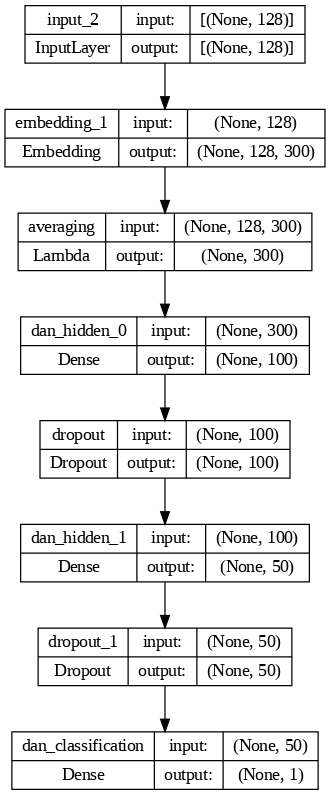

In [40]:
# Now call our function to create a DAN model, and show the model diagram

hidden_layer_sizes = [100, 50]
dropout_rate = 0.5

dan_model = build_dan_model(hidden_layer_sizes, dropout_rate)
keras.utils.plot_model(dan_model, show_shapes=True, dpi=90)

In [41]:
dan_history = dan_model.fit(train_input,
                            train_labels,
                            validation_data=(test_input, test_labels),
                            batch_size=32,
                            epochs=20
                            )

Epoch 1/20
625/625 [==============================] - 4s 4ms/step - loss: 0.6378 - accuracy: 0.6371 - val_loss: 0.5567 - val_accuracy: 0.7212
Epoch 2/20
625/625 [==============================] - 2s 3ms/step - loss: 0.5322 - accuracy: 0.7421 - val_loss: 0.5077 - val_accuracy: 0.7542
Epoch 3/20
625/625 [==============================] - 3s 4ms/step - loss: 0.5088 - accuracy: 0.7576 - val_loss: 0.5065 - val_accuracy: 0.7540
Epoch 4/20
625/625 [==============================] - 3s 4ms/step - loss: 0.4950 - accuracy: 0.7634 - val_loss: 0.4858 - val_accuracy: 0.7636
Epoch 5/20
625/625 [==============================] - 2s 4ms/step - loss: 0.4881 - accuracy: 0.7677 - val_loss: 0.4789 - val_accuracy: 0.7712
Epoch 6/20
625/625 [==============================] - 2s 3ms/step - loss: 0.4836 - accuracy: 0.7690 - val_loss: 0.4923 - val_accuracy: 0.7616
Epoch 7/20
625/625 [==============================] - 2s 4ms/step - loss: 0.4755 - accuracy: 0.7760 - val_loss: 0.4732 - val_accuracy: 0.7698
Epoch 

Let us compare the two *models*

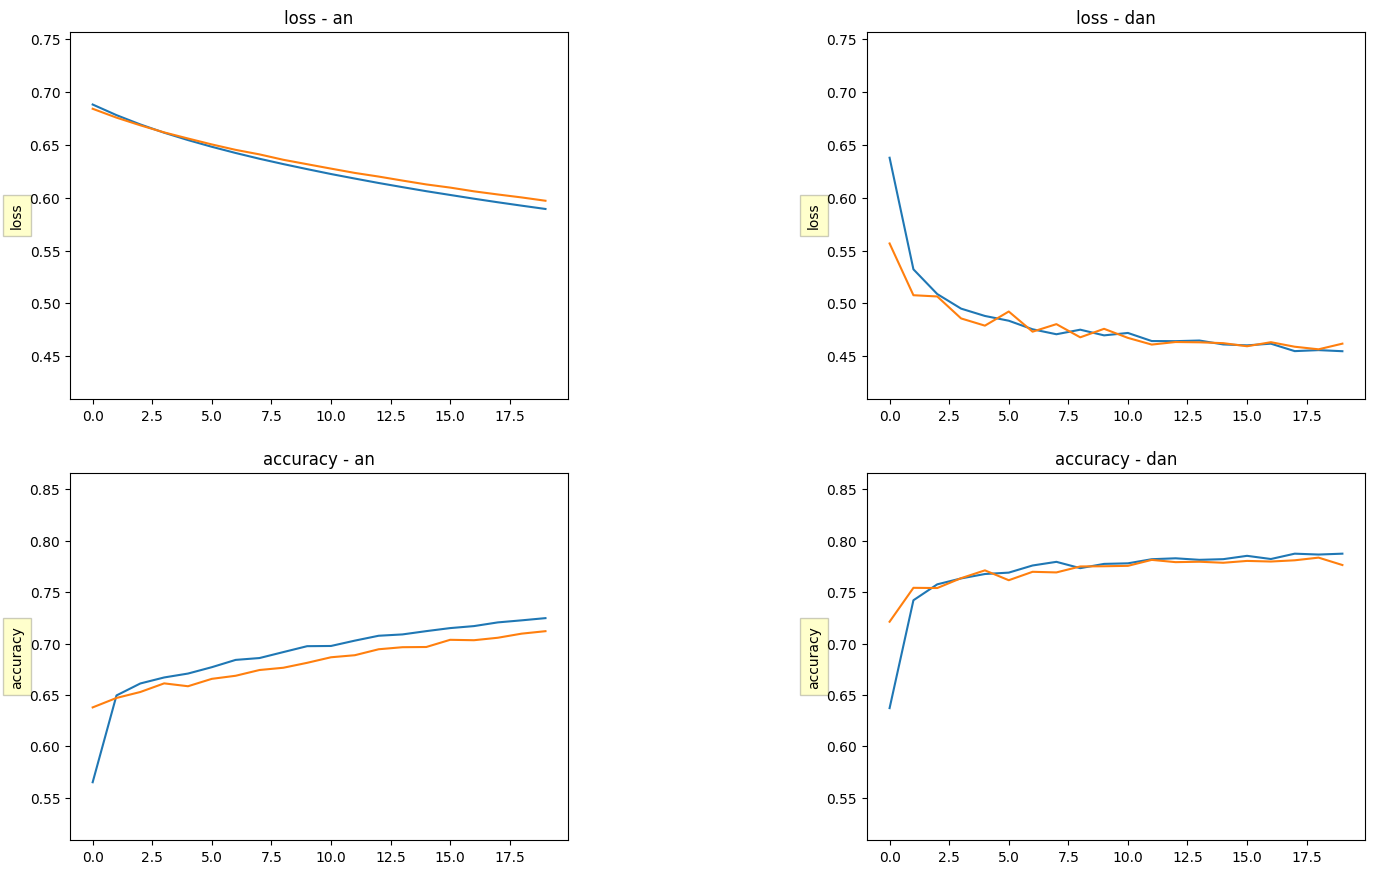

In [42]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          an_history,
          dan_history,
          model_1_name='an',
          model_2_name='dan')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

In [43]:
print('predictions:\n', dan_model.predict(train_input[:5]))
print('\n\nlabels:\n', train_labels[:5])

1/1 [==============================] - 0s 81ms/step
predictions:
 [[0.00458495]
 [0.21853893]
 [0.6062336 ]
 [0.8863974 ]
 [0.55013615]]


labels:
 [0 0 0 1 1]


[Return to Top](#returnToTop)  
<a id = 'modelCNN'></a>
### 3.3 CNN Model

Next let's build a CNN model. We'll also wrap the model building code in a function that takes some hyperparameters, so that we can adjust things like number of filters and filter sizes later.

In [44]:
def build_cnn_model(num_filters, kernel_sizes, dense_layer_dims, dropout_rate, embeddings_trainable=False):
    cnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    cnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    cnn_embeddings = cnn_embedding_layer(cnn_input_layer)

    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(cnn_embeddings)
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)

    conv_output = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
    last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(conv_output)

    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)

    cnn_prediction = keras.layers.Dense(1, activation='sigmoid')(last_hidden_output)

    cnn_model = keras.Model(inputs=cnn_input_layer, outputs=cnn_prediction)
    cnn_model.compile(optimizer='adam',
                      loss='binary_crossentropy',  # From information theory notebooks.
                      metrics=['accuracy'])
    return cnn_model

In [45]:
# Now specify model hyperparameters and call the function to create a CNN model

num_filters = [100, 100, 50, 25]
kernel_sizes = [3, 4, 5, 10]
dense_layer_dims = [100, 50]
dropout_rate = 0.5

cnn_model = build_cnn_model(num_filters, kernel_sizes, dense_layer_dims, dropout_rate)

In [46]:
cnn_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 128, 300)             1319460   ['input_3[0][0]']             
                                                          0                                       
                                                                                                  
 conv1d (Conv1D)             (None, 126, 100)             90100     ['embedding_2[0][0]']         
                                                                                                  
 conv1d_1 (Conv1D)           (None, 125, 100)             120100    ['embedding_2[0][0]']   

KERAS utility prints it better

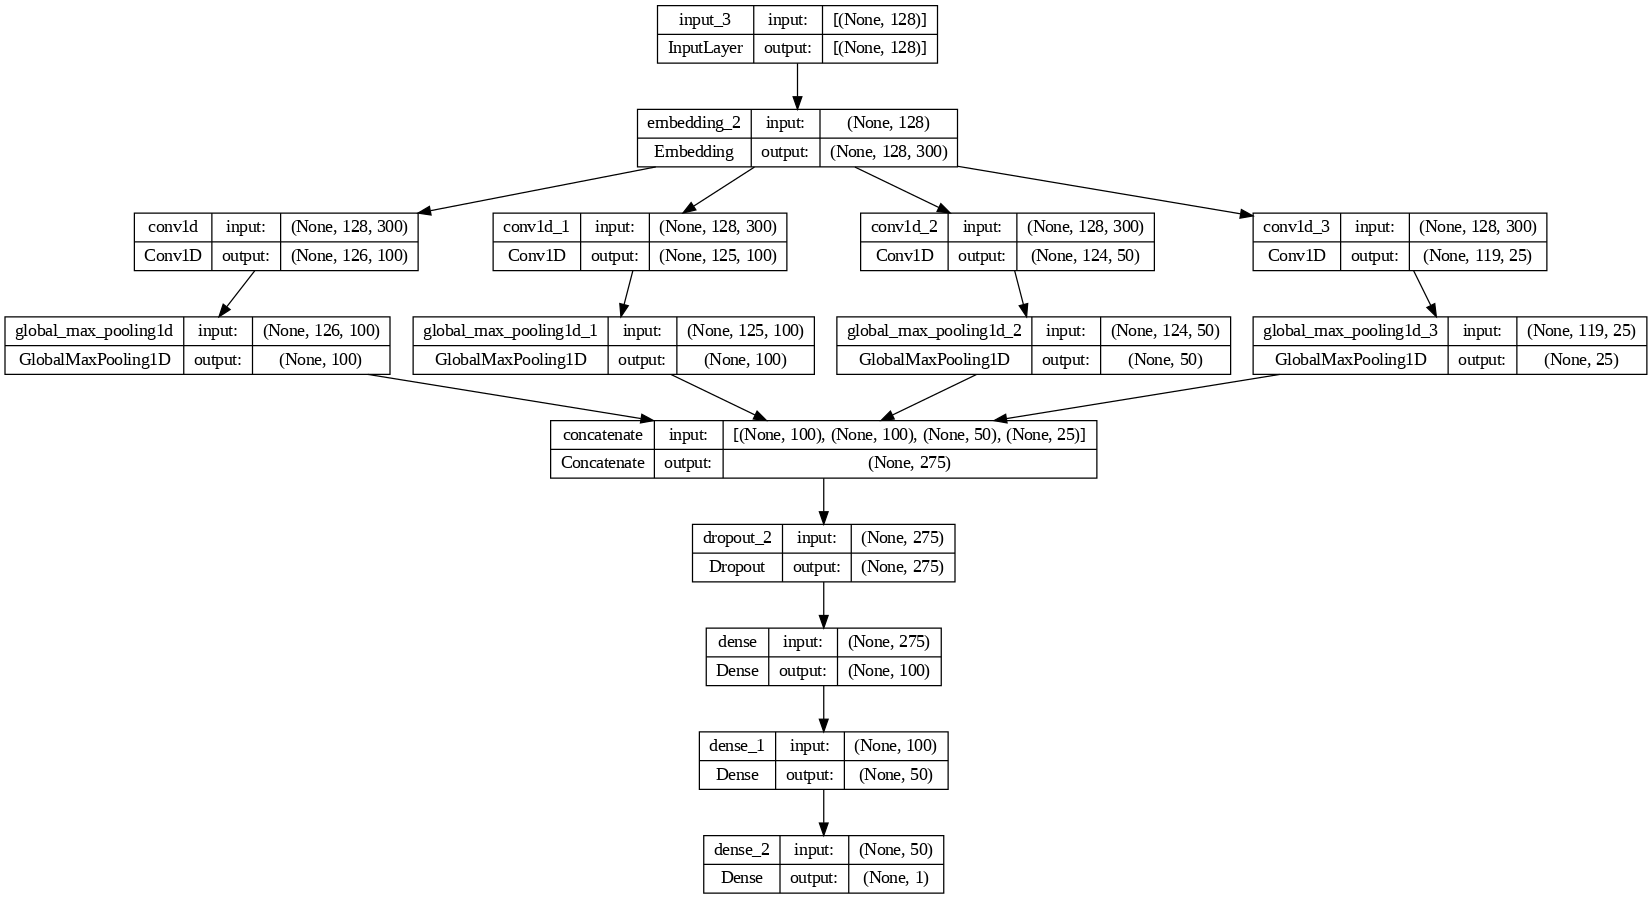

In [47]:
keras.utils.plot_model(cnn_model, show_shapes=True, dpi=90)

train CNN model

In [48]:
cnn_history = cnn_model.fit(train_input,
                            train_labels,
                            validation_data=(test_input, test_labels),
                            batch_size=32,
                            epochs=5
                            )

Epoch 1/5
625/625 [==============================] - 14s 8ms/step - loss: 0.5422 - accuracy: 0.7069 - val_loss: 0.4497 - val_accuracy: 0.7836
Epoch 2/5
625/625 [==============================] - 4s 6ms/step - loss: 0.4221 - accuracy: 0.8076 - val_loss: 0.4070 - val_accuracy: 0.8152
Epoch 3/5
625/625 [==============================] - 4s 6ms/step - loss: 0.3682 - accuracy: 0.8368 - val_loss: 0.3959 - val_accuracy: 0.8184
Epoch 4/5
625/625 [==============================] - 4s 7ms/step - loss: 0.3231 - accuracy: 0.8612 - val_loss: 0.4093 - val_accuracy: 0.8166
Epoch 5/5
625/625 [==============================] - 4s 7ms/step - loss: 0.2773 - accuracy: 0.8829 - val_loss: 0.4120 - val_accuracy: 0.8142


Compare DAN and CNN model

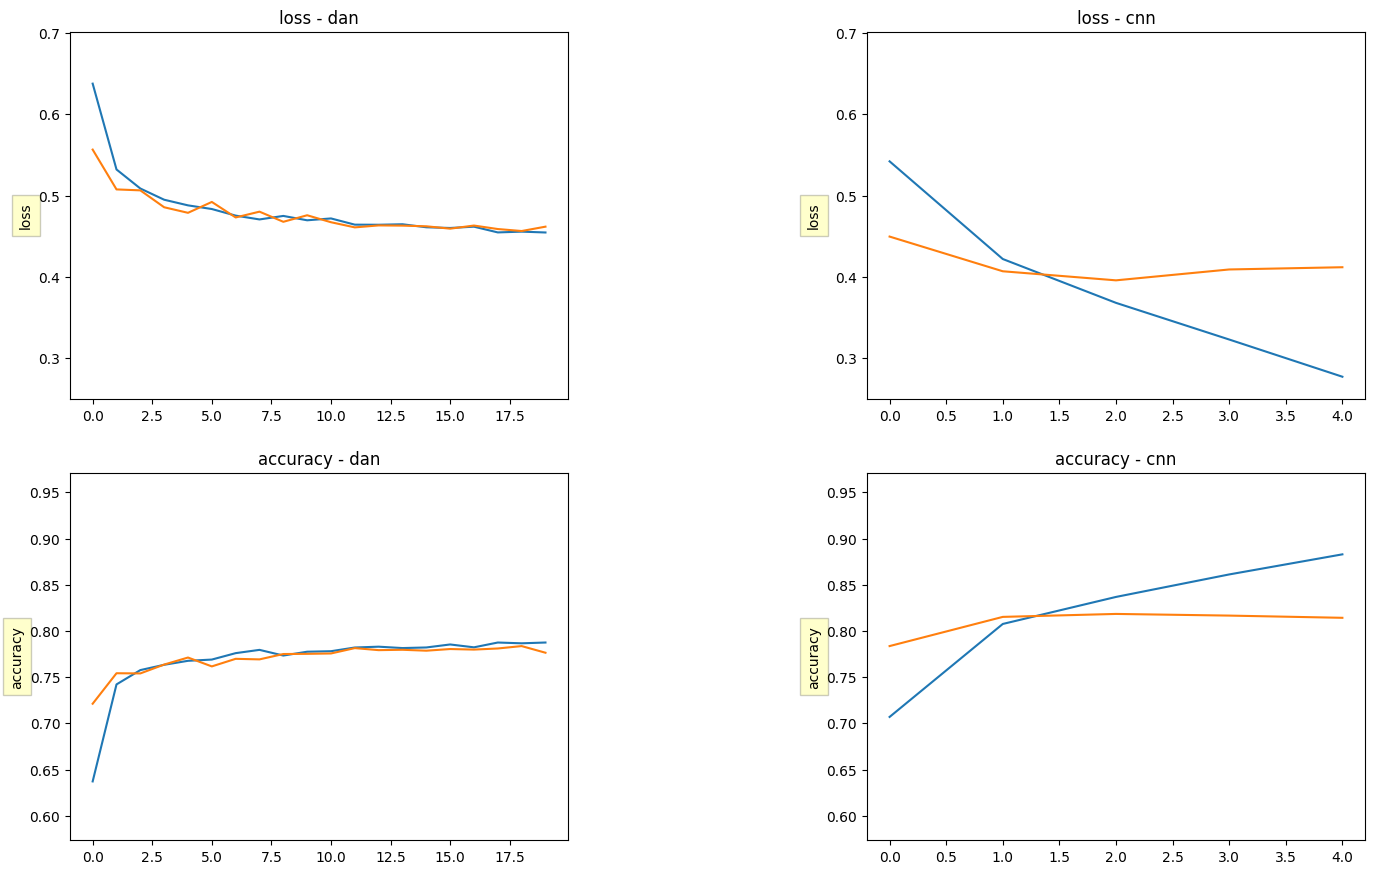

In [49]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          dan_history,
          cnn_history,
          model_1_name='dan',
          model_2_name='cnn')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

In [50]:
print('predictions:\n', cnn_model.predict(train_input[:5]))
print('\n\nlabels:\n', train_labels[:5])

1/1 [==============================] - 0s 235ms/step
predictions:
 [[0.00096005]
 [0.0382301 ]
 [0.0965616 ]
 [0.95230323]
 [0.79806834]]


labels:
 [0 0 0 1 1]


[Return to Top](#returnToTop)  
<a id = 'modelRNN'></a>
### 3.4 Recurrent Neural Network (RNN)

We now will now look at RNNs. We will first use a simple example to look at the structure of the model, and then use it also for classification of the same dataset that we used above.

#### 3.4.1. Basic Tests

Here is a very simple LSTM model with Keras.  For more details on much more complex uses of RNNs, see [this Keras guide](https://keras.io/guides/working_with_rnns/).

In [ ]:
def build_basic_rnn_model(max_length,
                          rnn_dim,
                          return_sequences,
                          return_state):
    """
    max_length:         maximum input length
    rnn_dim:            dimension of the rnn
    return_sequences:   should the entire sequence of output vectors for each time step be returned?
    return_state:       should the final cell states get returned?
    """

    # inputs - comprised of - for each example in mini-batch:
    #             - (<max_length>) x_t, each of dim <rnn_dim>,
    #.            - the initial 2 x 3d state (h and c)

    in_x = tf.keras.layers.Input(shape=(max_length, rnn_dim), name="in_id")
    in_state_h = tf.keras.layers.Input(shape=(rnn_dim,), name="in_state_h")
    in_state_c = tf.keras.layers.Input(shape=(rnn_dim,), name="in_state_c")

    # define a very simple lstm layer, acting on the input

    lstm_output = tf.keras.layers.LSTM(rnn_dim, return_sequences=return_sequences, return_state=return_state)\
            (in_x, initial_state=[in_state_h, in_state_c])

    model = tf.keras.models.Model(inputs=[in_x, in_state_h, in_state_c], outputs=lstm_output)

    return model